In [1]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import fast_dsift, no_op, hog, dsift

from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images

from menpofit.aam import (
    AAMBuilder, PatchAAMBuilder, LinearAAMBuilder, LinearPatchAAMBuilder, PartsAAMBuilder,
    LucasKanadeAAMFitter,
    WibergInverseCompositional, 
    ProjectOutInverseCompositional,
    AlternatingInverseCompositional,
    ModifiedAlternatingInverseCompositional,
    SimultaneousInverseCompositional,
    holistic_sampling_from_step)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=25):
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

Importing assets: [==========] 100% (25/25) - 00:00:00 remaining


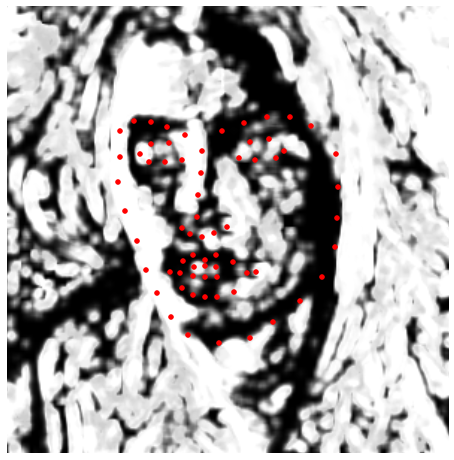

In [3]:
fast_dsift(i).view_widget()

## Load test data

In [5]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/testset/', 
                           verbose=True, max_images=25):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

Importing assets: [==========] 100% (25/25) - 00:00:00 remaining


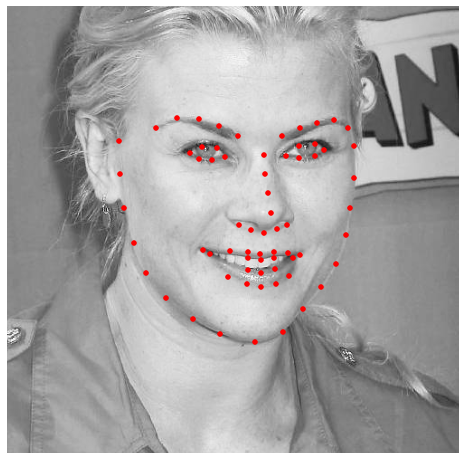

In [6]:
visualize_images(test_images)

## Build Active Appearance Models

In [7]:
features = fast_dsift
diagonal = 100
scales = (1, .5)
scale_shapes = False
scale_features = True
max_shape_components= 25
max_appearance_components = 200

#### AAM

In [8]:
aam_builder = AAMBuilder(
    features=features,
    diagonal=diagonal, 
    scales=scales, 
    scale_shapes=scale_shapes,
    scale_features=scale_features,
    max_shape_components=max_shape_components,
    max_appearance_components=max_appearance_components)

aam_batch = aam_builder.build(
    training_images, 
    group='ibug_face_66', 
    verbose=True)

- Building models
  - Level 0: Done
  - Level 1: Done


In [9]:
aam_incremental = aam_builder.build_incrementally(
    training_images, 
    group='ibug_face_66',
    batch_size=500,
    verbose=True)

AttributeError: 'AAMBuilder' object has no attribute 'build_incrementally'

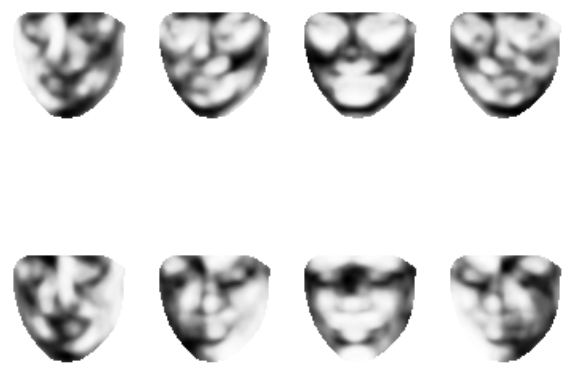

In [10]:
aam_batch.appearance_models[0].mean().view()

In [ ]:
aam_incremental.appearance_models[0].mean().view()

## Fit Active Appearance Models

#### AAM Fitters at different sampling rates

In [12]:
aam = aam_batch

In [13]:
lk_algorithm_cls = WibergInverseCompositional
n_shape = [5, 15]
n_appearance = [50, 100]

In [14]:
sampling_2, mask_2 = holistic_sampling_from_step(aam, step=2)
sampling_4, mask_4 = holistic_sampling_from_step(aam, step=4)
sampling_8, mask_8 = holistic_sampling_from_step(aam, step=8)

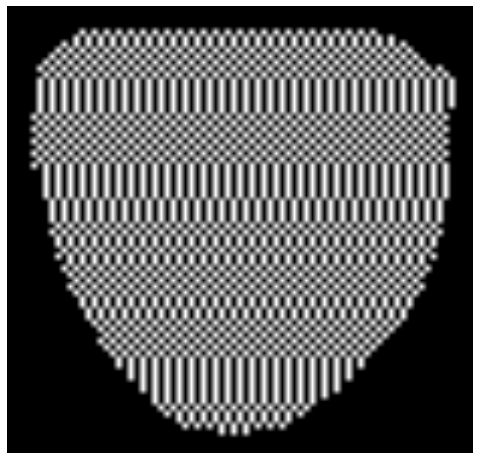

In [15]:
mask_2.view()

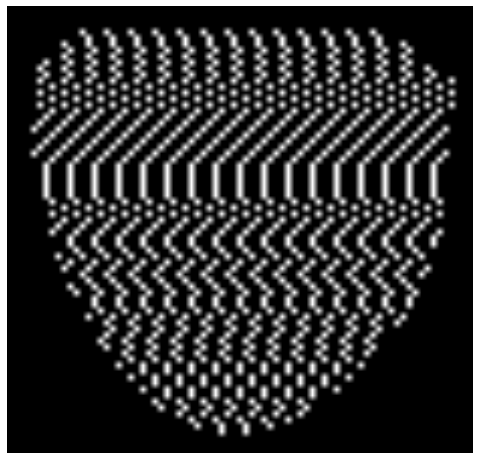

In [16]:
mask_4.view()

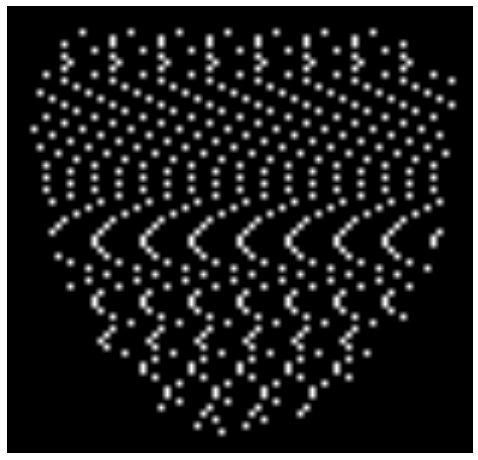

In [17]:
mask_8.view()

In [18]:
aam_fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=lk_algorithm_cls, 
    n_shape=n_shape, 
    n_appearance=n_appearance)

In [19]:
aam_fitter_2 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=lk_algorithm_cls, 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_2)

In [20]:
aam_fitter_4 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=lk_algorithm_cls, 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_4)

In [21]:
aam_fitter_8 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=lk_algorithm_cls, 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_8)

#### Fitting loop

In [22]:
fitters = [aam_fitter_1,
           aam_fitter_2,
           aam_fitter_4,
           aam_fitter_8]
           
fitters_results = []

for j, i in enumerate(test_images[:]):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    np.random.seed(2)
    s = fitters[0].noisy_shape_from_shape(gt_s, noise_std=0.0)

    for fitter in fitters:
        
        fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print 'Image: ', j
        print fr

Image:  0
Initial error: 0.1358
Final error: 0.0338
Image:  0
Initial error: 0.1358
Final error: 0.0337
Image:  0
Initial error: 0.1358
Final error: 0.0357
Image:  0
Initial error: 0.1358
Final error: 0.0380
Image:  1
Initial error: 0.1021
Final error: 0.0363
Image:  1
Initial error: 0.1021
Final error: 0.0353
Image:  1
Initial error: 0.1021
Final error: 0.0344
Image:  1
Initial error: 0.1021
Final error: 0.0359
Image:  2
Initial error: 0.0609
Final error: 0.0606
Image:  2
Initial error: 0.0609
Final error: 0.0603
Image:  2
Initial error: 0.0609
Final error: 0.0630
Image:  2
Initial error: 0.0609
Final error: 0.0610
Image:  3
Initial error: 0.1284
Final error: 0.0328
Image:  3
Initial error: 0.1284
Final error: 0.0332
Image:  3
Initial error: 0.1284
Final error: 0.0324
Image:  3
Initial error: 0.1284
Final error: 0.0390
Image:  4
Initial error: 0.0864
Final error: 0.0434
Image:  4
Initial error: 0.0864
Final error: 0.0433
Image:  4
Initial error: 0.0864
Final error: 0.0366
Image:  4
In

##  Results

In [23]:
initial_errors = [fr.initial_error() for fr in fitters_results[::4]]

final_errors_1 = [fr.final_error() for fr in fitters_results[::4]]
final_errors_2 = [fr.final_error() for fr in fitters_results[1::4]]
final_errors_4 = [fr.final_error() for fr in fitters_results[2::4]]
final_errors_8 = [fr.final_error() for fr in fitters_results[3::4]]

errors = [initial_errors, final_errors_1, final_errors_2, final_errors_4, final_errors_8]

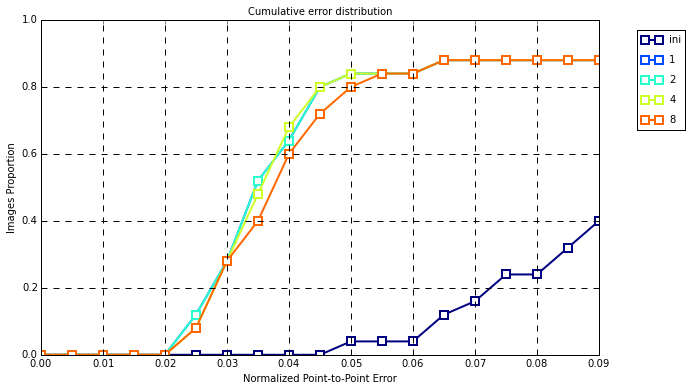

In [24]:
plot_ced(errors, legend_entries=['ini', '1', '2', '4', '8'])

In [25]:
print 'ini:', np.mean(initial_errors), 'std_1:', np.std(initial_errors), 'median:', np.median(initial_errors) 
print 'mean_1:', np.mean(final_errors_1), 'std_1:', np.std(final_errors_1), 'median:', np.median(final_errors_1) 
print 'mean_2:', np.mean(final_errors_2), 'std_2:', np.std(final_errors_2), 'median:', np.median(final_errors_2) 
print 'mean_4:', np.mean(final_errors_4), 'std_4:', np.std(final_errors_4), 'median:', np.median(final_errors_4) 
print 'mean_8:', np.mean(final_errors_8), 'std_8:', np.std(final_errors_8), 'median:', np.median(final_errors_8) 

ini: 0.112566687735 std_1: 0.0454787232392 median: 0.102075364424
mean_1: 0.0542575185008 std_1: 0.0586386411577 median: 0.033846198843
mean_2: 0.05339951193 std_2: 0.0563694360611 median: 0.0336805794107
mean_4: 0.0523458404869 std_4: 0.0527670829769 median: 0.0352077743956
mean_8: 0.0574027684736 std_8: 0.0586157723974 median: 0.0379693802788


In [26]:
from scipy import stats  

# ANOVA test
f_val, p_val1 = stats.f_oneway(final_errors_1, final_errors_2, 
                              final_errors_4, final_errors_8)  

# Kruskal-Wallis H-test
h_stat, p_val2 = stats.kruskal(final_errors_1, final_errors_2, 
                             final_errors_4, final_errors_8)

print "One-way ANOVA,", "\tp-value:", p_val1, "f-value:", f_val
print "Kruskal-Wallis," "\tp-value:", p_val2, "h-stat:", h_stat  

One-way ANOVA, 	p-value: 0.990977914349 f-value: 0.0355196666055
Kruskal-Wallis,	p-value: 0.895953499831 h-stat: 0.602091089109


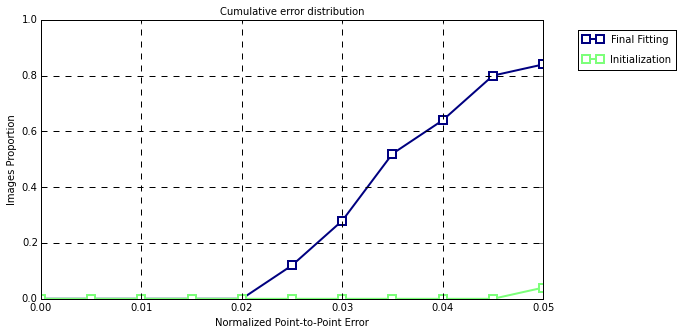

In [27]:
visualize_fitting_result(fitters_results[::4])

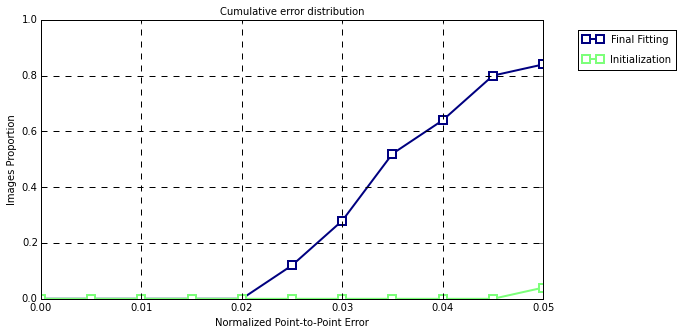

In [28]:
visualize_fitting_result(fitters_results[1::4])

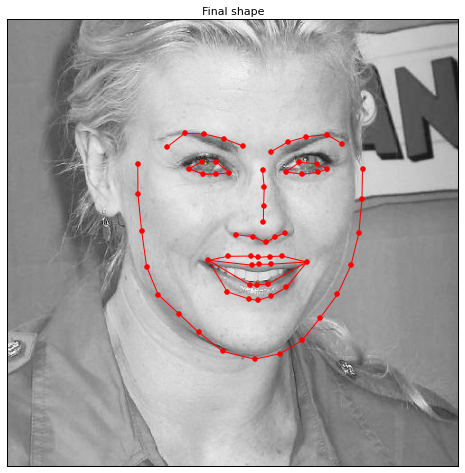

In [29]:
visualize_fitting_result(fitters_results[2::4])

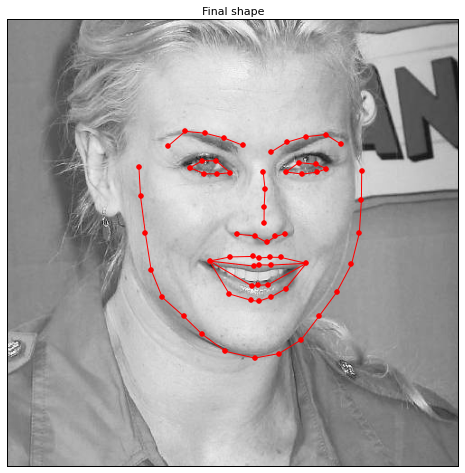

In [30]:
visualize_fitting_result(fitters_results[3::4])

In [31]:
%timeit -n 25 fr = aam_fitter_1.fit(i, s, gt_shape=gt_s, max_iters=20) 
%timeit -n 25 fr = aam_fitter_2.fit(i, s, gt_shape=gt_s, max_iters=20) 
%timeit -n 25 fr = aam_fitter_4.fit(i, s, gt_shape=gt_s, max_iters=20) 
%timeit -n 25 fr = aam_fitter_8.fit(i, s, gt_shape=gt_s, max_iters=20) 

25 loops, best of 3: 337 ms per loop
25 loops, best of 3: 228 ms per loop
25 loops, best of 3: 184 ms per loop
25 loops, best of 3: 166 ms per loop
